# Data Saving

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
def save_result():
  save_dir = "/content/drive/My Drive/training_results"
  os.makedirs(save_dir, exist_ok=True)
  # np.savetxt(f"{save_dir}/{model_path}_train_err.csv", train_err)


def save_weight(net, model_code):
  """model code will be a string code we assigned to each model"""
  weight_dir = "/content/drive/My Drive/model_weights"
  os.makedirs(weight_dir, exist_ok=True)

  model_path = os.path.join(weight_dir, model_code)
  torch.save(net.state_dict(), f"{model_path}.pth")


def load_weight(net, model_code):
  """model code will be a string code we assigned to each model"""
  weight_dir = "/content/drive/My Drive/model_weights"
  model_path = os.path.join(weight_dir, model_code)

  net.load_state_dict(torch.load(f"{model_path}.pth"))
  net.eval()
  return net

In [ ]:
# use case here

# large_net = LargeNet()
# train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=10)
# # train_net(large_net, batch_size=256, learning_rate=0.005, num_epochs=10)
# # train_net(large_net, batch_size=1056, learning_rate=0.003, num_epochs=10)
# plot_training_curve(get_model_name(large_net.name, 1056, 0.003, 9))

# save_weight(large_net, "large_net_test_1")
# new_large_net = LargeNet()
# new_large_net = load_weight(new_large_net, "large_net_test_1")
# train_loader, val_loader, test_loader, classes = get_data_loader(
#     target_classes=["cat", "dog"],
#     batch_size=64)

# evaluate(new_large_net, test_loader, nn.BCEWithLogitsLoss())

# Imports and Constants

### Data Loading

In [ ]:
!pip install datasets

import torch
from torch import nn
from datasets import load_dataset
from torch.utils.data import DataLoader

In [3]:
LANGUAGES = ["en", "de", "nl", "sv", "da"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 100
TRAIN_BATCH = 3000
VAL_BATCH = 2000
OPTIMIZER = torch.optim.Adam
LOSS_FUNCTION = nn.CrossEntropyLoss()

### Data Processing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob # list out files in directory -> reading wave files

import librosa
import librosa.display
import IPython.display as ipd # play files

from itertools import cycle # colours and gimiks

# Download Dataset

In [5]:
# linking hugging face account
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read)

In [6]:
def load_data(languages, train_batch, val_batch):
  train_data = []
  val_data = []

  train_audio = []
  train_labels = []
  train_sr = []
  val_audio = []
  val_labels = []
  val_sr = []

  for i in range(len(languages)):
    # Load common voice 17 dataset training set with streaming, and enabling custom code (necessary to load dataset correctly)
    train_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="train", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))
    val_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="validation", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))

    it = iter(train_data[i])
    it2 = iter(val_data[i])

    for j in range(train_batch):
      train_item = next(it)

      if train_item:
        train_audio.append(train_item['audio']['array'])
        train_sr.append(train_item['audio']['sampling_rate'])
        train_labels.append(languages[i])

    for j in range(val_batch):
      val_item = next(it2)

      if val_item:
        val_audio.append(val_item['audio']['array'])
        val_sr.append(val_item['audio']['sampling_rate'])
        val_labels.append(languages[i])


    print(f"Loaded {languages[i]}")

  return train_audio, train_labels, train_sr, val_audio, val_labels, val_sr

In [ ]:
train_audio, train_labels, train_sr, val_audio, val_labels, val_sr = load_data(LANGUAGES, TRAIN_BATCH, VAL_BATCH)

Reading metadata...: 1101170it [00:27, 40042.49it/s]
Reading metadata...: 16393it [00:00, 32789.53it/s]


# Data Processing

In [7]:
# get spectrogram, mel spectrogram and MFCC for all data
spectogram = []
mel_spectogram = []
MFCC = []
samples = 2048 # the number of samples per fft
hop_length = 512 # the amount of transform to shift
n_mfcc = 13 # The number of coefficient we extract

for i in range(100):
    # spectrogram
    spectogram.append(librosa.amplitude_to_db(np.abs(train_audio[i]), ref=np.max))
    spectogram_trimmed,_ = librosa.effects.trim(train_audio[i], top_db=35) # trim audio

    # mel spectrogram
    S = librosa.feature.melspectrogram(y=train_audio[i], sr=train_sr[i], n_mels=128) # dummy

    mel_spectogram.append(librosa.amplitude_to_db(S, ref=np.max))
    mel_spectogram_trimmed,_ = librosa.effects.trim(train_audio[i], top_db=35) # trim audio

    MFCC.append(librosa.feature.mfcc(y=np.abs(train_audio[i]), sr=train_sr[i], n_fft=samples, hop_length=hop_length, n_mfcc=n_mfcc))

print(MFCC[30].shape)
print(MFCC[30])

(13, 307)
[[-6.51042873e+02 -6.51042873e+02 -6.50859658e+02 ... -6.50223298e+02
  -6.50156680e+02 -6.50154274e+02]
 [ 0.00000000e+00  0.00000000e+00  2.59085938e-01 ...  1.15896686e+00
   1.25317170e+00  1.25641938e+00]
 [ 0.00000000e+00  0.00000000e+00  2.59027411e-01 ...  1.15870505e+00
   1.25288860e+00  1.25567275e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  2.57156855e-01 ...  1.15033751e+00
   1.24384092e+00  1.23197521e+00]
 [ 0.00000000e+00  0.00000000e+00  2.56748272e-01 ...  1.14850980e+00
   1.24186465e+00  1.22684139e+00]
 [ 0.00000000e+00  0.00000000e+00  2.56301023e-01 ...  1.14650912e+00
   1.23970135e+00  1.22123912e+00]]


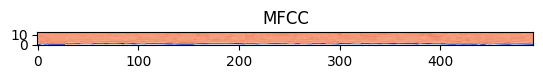

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

TEST_INDEX = 80

fig, ax = plt.subplots()
cax = ax.imshow(MFCC[TEST_INDEX], interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()

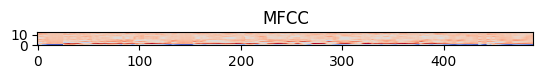

In [13]:
import torchaudio

mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=train_sr[TEST_INDEX],
        n_mfcc=n_mfcc,
        melkwargs={"n_fft": samples, "hop_length": hop_length, "n_mels": 128, "center": False},
)

signal = mfcc_transform(torch.tensor(train_audio[TEST_INDEX], dtype=torch.float32))
fig, ax = plt.subplots()
cax = ax.imshow(signal, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()

# CNN Model

### Papers

This one for backup, but the f1 scores kinda sucked so I didnt use this one

https://portfolios.cs.earlham.edu/wp-content/uploads/2022/01/Lam_Final_paper.pdf

I roughly used the model shown in this paper because the f1 scores were pretty good. Changed the number of filters though, and opted out of the two linear layers at the end for just one.

https://www.ijert.org/research/a-deep-learning-cnn-model-for-tv-broadcast-audio-classification-IJERTV9IS110145.pdf

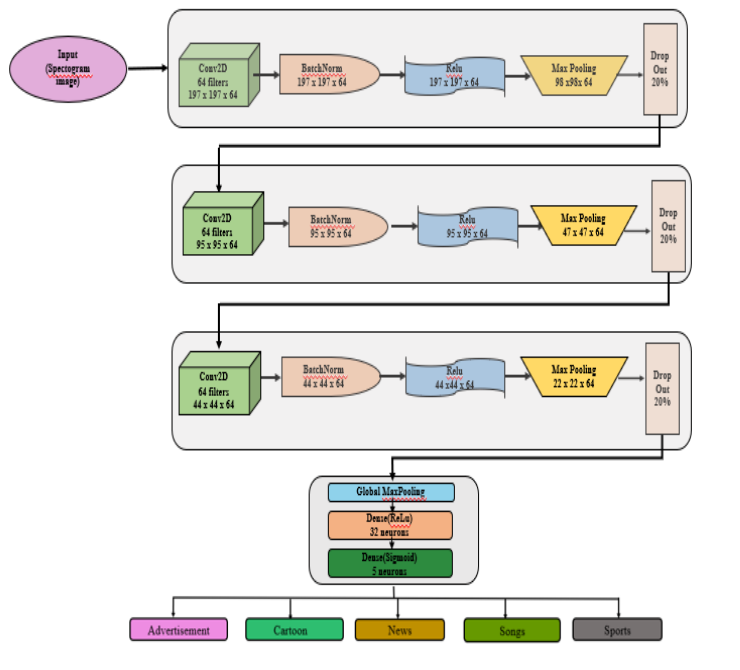

In [ ]:
class ConvNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.c1 = nn.Sequential(
      nn.Conv2d(
        in_channels=1,
        out_channels=32,
        kernel_size=3,
        stride=1,
        padding=2
      ),
      nn.BatchNorm1d(),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
      nn.Dropout(p=0.2)
    )

    self.c2 = nn.Sequential(
      nn.Conv2d(
        in_channels=32,
        out_channels=64,
        kernel_size=3,
        stride=1,
        padding=2
      ),
      nn.BatchNorm1d(),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
      nn.Dropout(p=0.2)
    )

    self.c3 = nn.Sequential(
      nn.Conv2d(
        in_channels=64,
        out_channels=128,
        kernel_size=3,
        stride=1,
        padding=2
      ),
      nn.BatchNorm1d(),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
      nn.Dropout(p=0.2)
    )

    self.global_max = nn.MaxPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(128, 10) # 128 * sm * sm... need to figure out the dimensions
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input):
    x = self.c1(input)
    x = self.c2(x)
    x = self.c3(x)
    x = self.global_max(x)
    x = self.flatten(x)
    x = self.linear(x)
    predictions = self.softmax(x)
    return predictions

### Train

In [ ]:
def train(model, data_loader, device, optimizer, loss_function, num_epochs):
  for epoch in range(num_epochs):
    print("Epoch #", epoch, "|")
    for data, label in data_loader:
      data, label = data.to(device), label.to(device)

      output = model(data)
      loss = loss_function(output, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f"Epoch #{epoch} |")

print("Total time elapsed: ")

### Use Model

In [ ]:
cnn = ConvNetwork()